In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
# importing all the necessary libraries
# im gonna use the xgboost regression model and use the label encoder
# to transform the male and female to 0 and 1 as xgb works better with num


In [10]:
train = pd.read_csv("train.csv",index_col="id")
test = pd.read_csv("test.csv",index_col="id")
train.head()
#loading the csv onto the df to get an overall idea

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [20]:
train.info()
train.describe()

# from here i can see that there is no need for fitting the non null value
# or taking care of it, since all the rows have values

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Sex         750000 non-null  object 
 1   Age         750000 non-null  int64  
 2   Height      750000 non-null  float64
 3   Weight      750000 non-null  float64
 4   Duration    750000 non-null  float64
 5   Heart_Rate  750000 non-null  float64
 6   Body_Temp   750000 non-null  float64
 7   Calories    750000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 51.5+ MB


,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


<Axes: xlabel='Heart_Rate', ylabel='Calories'>

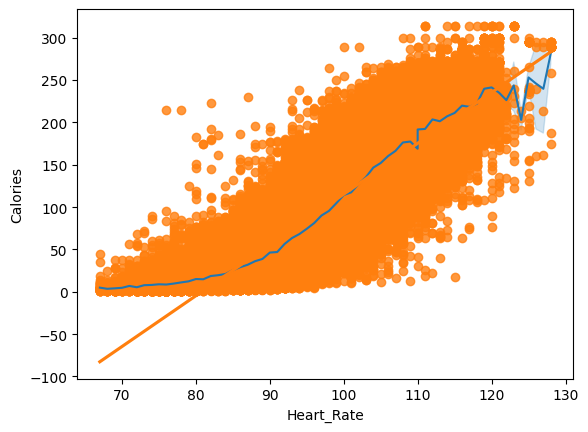

In [23]:
sns.lineplot(x=train["Heart_Rate"],y=train["Calories"])
# as per my assumptions higher heart rate definitely equal higher calor burn
sns.regplot(x=train["Heart_Rate"],y=train["Calories"])

In [24]:
train.columns

Index(['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
       'Calories'],
      dtype='object')

In [26]:
new_col = train.select_dtypes(include='object').columns

le = LabelEncoder()
for col in new_col:
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])
# after thourough research it seems that men and women sweat difreently 
# hence i am converting their columns to 0 nd 1 as xgb works better like that

In [30]:
X = train.drop(columns=["Calories"])
y= train["Calories"]
X_train, X_val , y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=1)
# splitting the train and test data to train on xgb

In [ ]:
model = XGBRegressor(n_estimators =300, learning_rate=0.05,max_depth=6,random_state=1,n_jobs=-1)
model.fit(X_train,y_train)
y_val_preds = model.predict(X_val)
y_val_preds = np.maximum(0,y_val_preds)

# used local llms to ask for best settings for this model , kept random state
# as 1 at all times

In [ ]:
rmsle = np.sqrt(mean_squared_error(np.log1p(y_val), np.log1p(y_val_preds)))
print(f"Validation RMSLE: {rmsle:.5f}")
# calcualting the root mean sqwuared log vcalue to see the strength of the model
#looks pretty promising

Validation RMSLE: 0.06521


In [36]:
test_preds = model.predict(test)
test_preds = np.maximum(0, test_preds)

In [40]:
submission = pd.DataFrame({
    'id': test.index,
    'Calories_Burned': test_preds
})

submission.to_csv("submission.csv", index=False)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Load data
train = pd.read_csv("train.csv", index_col="id")
test = pd.read_csv("test.csv", index_col="id")

# Encode 'Sex' manually
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})
test['Sex'] = test['Sex'].map({'male': 0, 'female': 1})

# Feature engineering
for df in [train, test]:
    df['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)
    df['Heart_Temp_Ratio'] = df['Heart_Rate'] / df['Body_Temp']
    df['Effort'] = df['Duration'] * df['Heart_Rate']

# Define features and target
X = train.drop(columns=["Calories"])
y = np.log1p(train["Calories"])  # log-transform target
X_test = test.copy()

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)
model.fit(X_train, y_train,eval_set=[(X_val, y_val)],verbose=False)

# Predict and evaluate
y_val_preds = model.predict(X_val)
rmsle = np.sqrt(mean_squared_error(y_val, y_val_preds))
print(f"Validation RMSLE (log1p space): {rmsle:.5f}")

# Final test predictions (invert log1p)
test_preds = np.expm1(model.predict(X_test))
test_preds = np.maximum(0, test_preds)

# Submission
submission = pd.DataFrame({
    'id': test.index,
    'Calories_Burned': test_preds
})
submission.to_csv("submission.csv", index=False)


Validation RMSLE (log1p space): 0.06011


In [42]:
import xgboost
print(xgboost.__version__)


3.0.2


In [1]:
from xgboost import XGBRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=1000, n_features=10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

model.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False)


ModuleNotFoundError: No module named 'xgboost'